# Deforestation detection

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import xarray as xr

In [2]:
def normalized_difference(frame, positive, negative):
    return (frame[positive] - frame[negative])/(frame[positive] + frame[negative])

In [3]:
def to_table(dataset):

    flattened = (
        dataset.drop_vars("spatial_ref")
        .isel(x=5, y=5)
        .to_dataframe()
        .reset_index()
        .drop(columns=["x", "y"])
        .dropna(how="any")
        )
    
    flattened["NDVI"] = normalized_difference(flattened, "NIRnarrow", "Red")
    flattened["NDMI"] = normalized_difference(flattened, "NIRnarrow", "SWIR1")

    flattened["DOY"] = flattened["time"].dt.dayofyear
    return flattened

In [4]:
PARENT_DIR = Path("/home/iborlafm/Downloads/Mozambique/hls")

In [5]:
deforested_frame = to_table(xr.open_dataset(PARENT_DIR / "HLS_deforested_b30_v2.0.nc"))
intact_frame = to_table(xr.open_dataset(PARENT_DIR / "HLS_intact_b30_v2.0.nc"))

## Clouds and shadows taint our time series

In [6]:
cirrus_col = "cirrus cloud"
cloud_col = "cloud"
adjacent_col = "adjacent to cloud"
shadow_col = "cloud shadow"
tainted_cols = [adjacent_col, cloud_col, cirrus_col, shadow_col]

intact_masked = intact_frame[np.logical_not(intact_frame[tainted_cols].any(axis=1))].copy()
deforested_masked = deforested_frame[np.logical_not(deforested_frame[tainted_cols].any(axis=1))].copy()

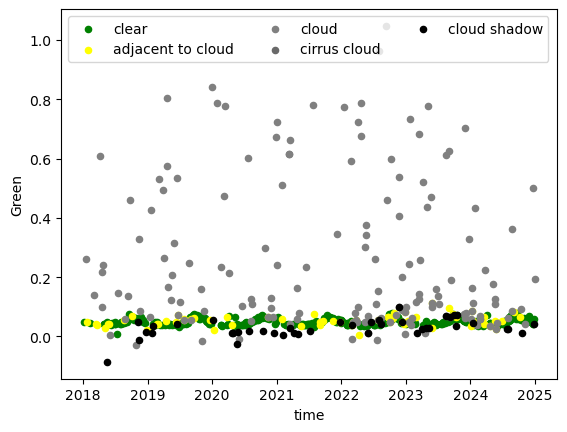

In [7]:
mask_fig, mask_panels = plt.subplots(1, 1);
mask_kwargs = {"x": "time", "y": "Green", "ax": mask_panels}

intact_masked.plot.scatter(color="green", **mask_kwargs, label="clear")

for sel, c in zip(tainted_cols, ["yellow", "gray", "dimgray", "black"]):
    (
        intact_frame[intact_frame[sel]]
        .plot.scatter(color=c, label=sel, **mask_kwargs)
        .legend(loc="upper left", ncols=3)
    )

## Removed the cloud, the timeline becomes clearer

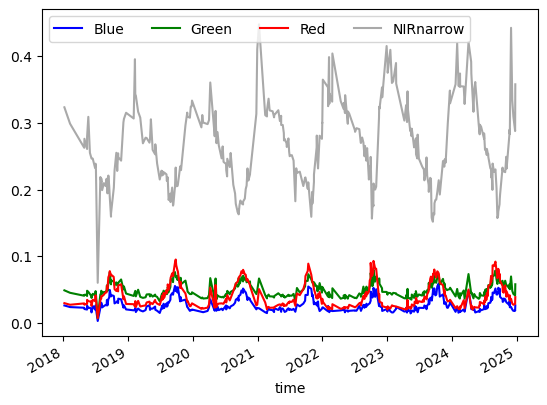

In [8]:
tetracolor_kwargs = {
    "x": "time",
    "y": ["Blue", "Green", "Red", "NIRnarrow"],
    "color": ["blue", "green", "red", "darkgray"]
    }

intact_masked.plot(**tetracolor_kwargs).legend(loc="upper left", ncols=4);

## Spikes could be unmasked clouds/shadows

A massive value difference respective to its neighbors indicates the presence of possible outliers

In [9]:
def despike(frame, columns, min_spike, max_spike):

    summed = frame[columns].sum(axis=1)
    
    # Perform the selections
    central = summed.iloc[1:-1]
    prior = summed.shift(-1).iloc[1:-1]
    posterior = summed.shift(1).iloc[1:-1]

    # 
    spikyness = central - (prior + posterior)/2
    floor, ceiling = spikyness.quantile((min_spike, max_spike))
    selected = central[spikyness.between(floor, ceiling)]

    return frame.loc[selected.index]

cutoff = .05
band_names = ['Blue', 'Green', 'Red', 'NIRnarrow', 'SWIR1', 'SWIR2']

intact_despiked = despike(intact_masked, band_names, cutoff, 1-cutoff)
deforested_despiked = despike(deforested_masked, band_names, cutoff, 1-cutoff)

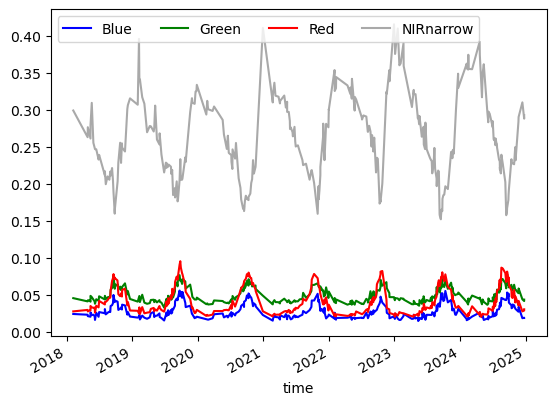

In [10]:
intact_despiked.plot(**tetracolor_kwargs).legend(loc="upper left", ncols=4);

## The spikes as anomalies

These spikes are anolalies on the context where they appear, but they may or
may not be global outliers when compared with the full population.

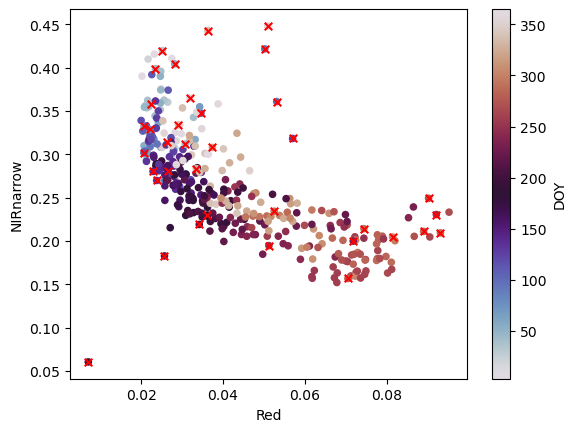

In [13]:
inlier_fig, inlier_panel = plt.subplots(1, 1)

intact_masked.plot.scatter(
    x="Red",
    y="NIRnarrow",
    c="DOY",
    colormap="twilight",
    ax=inlier_panel
    );

intact_masked.iloc[1:-1].drop(index=intact_despiked.index).plot.scatter(
    x="Red",
    y="NIRnarrow",
    marker="x",
    s=30,
    color="red",
    ax=inlier_panel
    );

The isolated points far above and below the general population would be
global outliers, whereas the rest were outliers on their specific context.

## The signature of deforestation

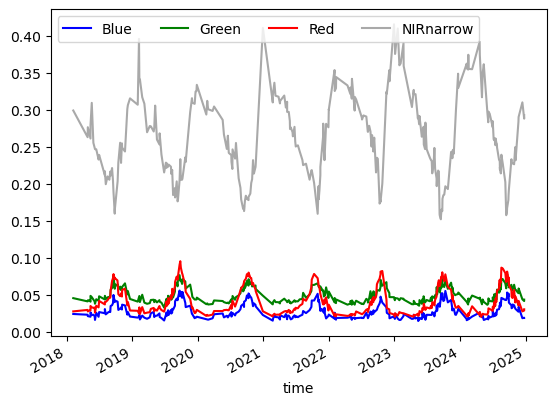

In [ ]:
intact_despiked.plot(**tetracolor_kwargs).legend(loc="upper left", ncols=4);

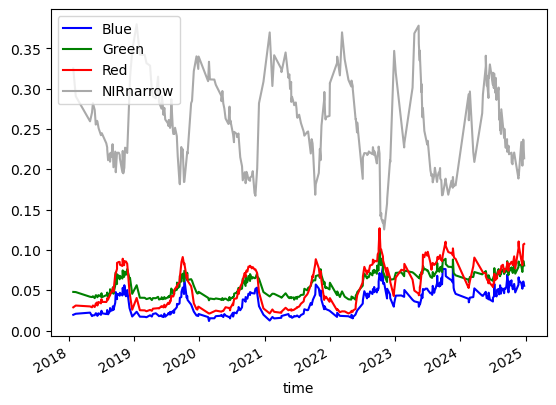

In [ ]:
deforested_despiked.plot(
    x="time",
    y=["Blue", "Green", "Red", "NIRnarrow"],
    color=["blue", "green", "red", "darkgray"]
    );
# plt.axvline(disturbance_time, color="k", linestyle="--");

## With Indices

Text(0, 0.5, 'NDVI')

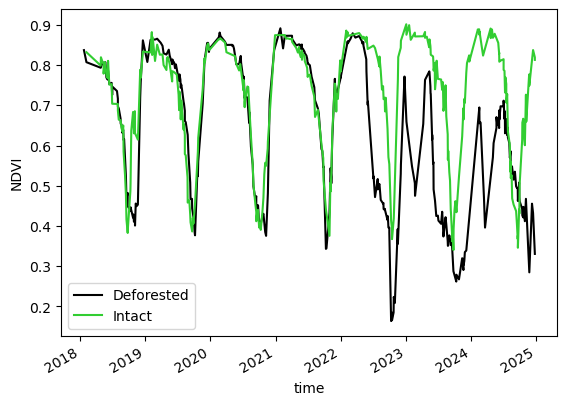

In [ ]:
logg_fig, logg_panel = plt.subplots(1, 1)

deforested_despiked.plot(x="time", y="NDVI", color="black", ax=logg_panel, label="Deforested");
intact_despiked.plot(x="time", y="NDVI", color="limegreen", ax=logg_panel, label="Intact");
logg_panel.set_ylabel("NDVI")